In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
import os
import json

# Import API keys
from config import blsapi

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_directory = "bls_api_csv"

# The BLS API requires you to submit a seriesID with every call.  The seriesID is a code that tells 
# BLS what data set you are requesting and it is a fairly complex formula to build the series.
# Each data set has a unique Format for the series id parameter.
# This site defines the series id format that must be used
# https://www.bls.gov/help/hlpforma.htm#OE
# this analysis focuses on Occupational Employment statistics 
# The data collection and purpose of this data set is defined 
# https://www.bls.gov/oes/oes_emp.htm

# 	Series ID    OEUN000000011100011000001
# 	Positions       Value           Field Name
# 	1-2             OE              Prefix
# 	3               U               Seasonal Adjustment Code
prefix = 'OE'
season_ad_cd = 'U'

# Area codes are defined
# https://download.bls.gov/pub/time.series/oe/oe.area
# 	4               N               Area Type Code
# 	5-11            0000000         Area Code
# Based on the reviewing the online version of the data only 5 NC area's have data relevant to this analysis
# 0016740	M	Charlotte-Concord-Gastonia, NC-SC	
# 0039580	M	Raleigh, NC	
# 0020500	M	Durham-Chapel Hill, NC	
# 0048900	M	Wilmington, NC	
# 0049180	M	Winston-Salem, NC	
# 3700000	S	North Carolina	

area_type_code = 'N'
area_code = '0000000'

area_data = pd.DataFrame({
    "area_type_code":["N","S","M","M","M","M","M"],
    "area_code":['0000000','3700000','0016740','0039580','0020500','0048900','0049180'],
    "area_name":['National','North Carolina','Charlotte-Concord-Gastonia, NC-SC', 'Raleigh, NC', 'Durham-Chapel Hill, NC', 'Wilmington, NC','Winston-Salem, NC' ]
})

# Industry codes are defined
# https://download.bls.gov/pub/time.series/oe/oe.industry
# 	12-17           111000          Industry Code
ind_code = '000000'

# We have decided to focus on the following occupations
# OCC_CODE	OCC_TITLE
# 13-1141	Compensation, Benefits, and Job Analysis Specialists
# 13-1161	Market Research Analysts and Marketing Specialists
# 13-2031	Budget Analysts
# 13-2041	Credit Analysts
# 13-2051	Financial Analysts
# 15-1121	Computer Systems Analysts
# 15-1122	Information Security Analysts
# 15-1141	Database Administrators
# 15-2011	Actuaries
# 15-2031	Operations Research Analysts
# 15-2041	Statisticians
# 	18-23           110000          Occupation Code
occ_code = ['131141','131161','132031','132041','132051','151121','151122','151141','152011','152031','152041']
occ_title = ['Compensation, Benefits, and Job Analysis Specialists','Market Research Analysts and Marketing Specialists',
            'Budget Analysts','Credit Analysts','Financial Analysts','Computer Systems Analysts','Information Security Analysts',
            'Database Administrators','Actuaries', 'Operations Research Analysts', 'Statisticians']

# buils a base dataframe to capture the occupation data
data_set = pd.DataFrame({"Occupation Code": occ_code,
           "Occupation Title": occ_title})

# The list of data types can be found
# https://download.bls.gov/pub/time.series/oe/oe.datatype
# 	24-25           01              Data Type Code
# 01	Employment
# 04	Annual mean wage	
# 13	Annual median wage	
# 16	Employment per 1,000 jobs	
# 17	Location Quotient	
# based on the data limitations the API call will be one for each data type.  Then 
data_types = ['01','04','13']
data_type_name = ['Employment','Annual mean wage', 'Annual median wage']


In [2]:
# build series list
# per API restrictions a single API call cannot contain more than 25 series IDs
# based on deadline I am making this code less DRY to get it done.  Due to this I am reducing this 25 limit so I get one API
# call per data type.  I will build a CSV with all my data so I can chart it.  This API only lets you return one data value
# per series call.
apiserieslimit = 12
maxocc = round(apiserieslimit/(len(occ_code)+1))

for areaindex in range(len(area_data)):
    data_set = pd.DataFrame({"Occupation Code": occ_code,
                             "Occupation Name": occ_title,
                             "Location": area_data["area_name"][areaindex]})
    series_list = []
    for apirun in data_types:
        for occup in occ_code:
            series_list.append(prefix + season_ad_cd + area_data["area_type_code"][areaindex] + area_data["area_code"][areaindex] + ind_code + occup + apirun)
#            series_list.append(prefix + season_ad_cd + "M" + "0020500" + ind_code + occup + apirun)
        if ((data_types.index(apirun)+1)%maxocc == 0) or data_types.index(apirun)+1 == len(data_types):
    # the following code came from the BLS code sample page that shows how to call the API
    # my series data only has data from 2017
            headers = {'Content-type': 'application/json'}
            data = json.dumps({"seriesid": series_list,"startyear":"2017", "endyear":"2017", "registrationkey": blsapi})
            p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
            json_data = json.loads(p.text)
            series_list = []
    # add a sleep just to be safe with API calls
            time.sleep(2)
    # add the data collected to the data frame
        seriesid = []
        keyvalue = []
        for x in range(len(json_data['Results']['series'])):
            # Only add the data value if the series has data for the series
#             if len(json_data['Results']['series'][x]['data']) == 0:
#                 print(len(json_data['Results']['series'][x]['data']))
            if len(json_data['Results']['series'][x]['data']) > 0:
                seriesid.append(json_data['Results']['series'][x]['seriesID'][-8:-2])
                keyvalue.append(json_data['Results']['series'][x]['data'][0]['value'])

        keyvalue_header = json_data['Results']['series'][x]['seriesID'][-2:]
        data_collector = pd.DataFrame({"Occupation Code": seriesid,
                                       data_type_name[data_types.index(keyvalue_header)]: keyvalue})

        data_set = pd.merge(data_set, data_collector, on="Occupation Code", how="outer")


    output_data_file = area_data["area_name"][areaindex].replace(" ", "_") + ".csv"
    output_full_path = output_directory + "/" + output_data_file

    data_set.to_csv(output_full_path, encoding='utf-8', index=False)
    print(f"{output_data_file} created...({areaindex+1} of {len(area_data)})")


National.csv created...(1 of 7)
North_Carolina.csv created...(2 of 7)
Charlotte-Concord-Gastonia,_NC-SC.csv created...(3 of 7)
Raleigh,_NC.csv created...(4 of 7)
Durham-Chapel_Hill,_NC.csv created...(5 of 7)
Wilmington,_NC.csv created...(6 of 7)
Winston-Salem,_NC.csv created...(7 of 7)


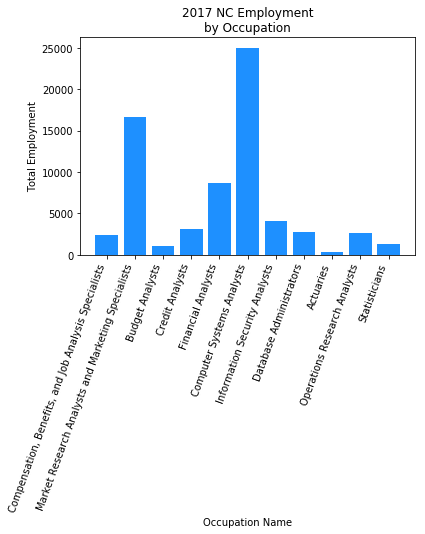

In [24]:

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


input_directory = "bls_api_csv/"

#collect NC data for charting
input_full_path = input_directory + "North_Carolina.csv"
nc_data = pd.read_csv(input_full_path, encoding="utf-8")

#collect NC data for charting
input_full_path = input_directory + "National.csv"
national_data = pd.read_csv(input_full_path, encoding="utf-8")


# define an employment chart based on occupation name
plt.bar(nc_data['Occupation Name'], nc_data['Employment'], color="dodgerblue")
        
# set the xticks to label all Occupation Names
plt.xticks(nc_data['Occupation Name'], rotation=70, ha="right")

# add a title using the city type and day
plt.title('2017 NC Employment\nby Occupation')

# add the x and y labels
plt.xlabel('Occupation Name')
plt.ylabel('Total Employment')

# save the figure

plt.savefig(input_directory + "NC_Employment.png", bbox_inches='tight')


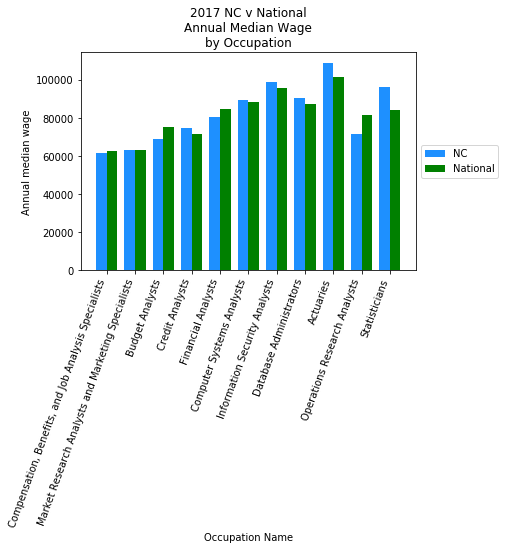

In [48]:
width = .75
fig = plt.figure()
ax = fig.add_subplot(111)


xticks = np.arange(len(nc_data['Occupation Name']))

# define an employment chart based on occupation name
plt.bar(xticks, nc_data['Annual median wage'], width = .5*width, color="dodgerblue", label="NC")
plt.bar(xticks+(.5*width), national_data['Annual median wage'], width = .5*width, color="green", label="National")

# set the xticks to label all Occupation Names
ax.set_xticks(nc_data['Occupation Name'].index+(.25*width))
ax.set_xticklabels(nc_data['Occupation Name'], rotation=70, ha="right")
# ax.xticks(nc_data['Occupation Name'], rotation=70, ha="right")

# add a title using the city type and day
plt.title(f'2017 NC v National\nAnnual Median Wage\nby Occupation')

# add the x and y labels
plt.xlabel('Occupation Name')
plt.ylabel('Annual median wage')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save the figure

plt.savefig(input_directory + "NC_median_wage.png", bbox_inches='tight')
